# Process signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from atmospheric_lidar import licelv2
import glob
import os
#from atmospheric_lidar.licel import LicelLidarMeasurement
from lifa.licel import LicelLidarMeasurement

## Load measurement file

In [32]:
# Measurements directories to compare
#files = ['./sample_data/measurement_1/a24C0506.105499']

#files = ['./sample_data/measurement_1/a24C0506.105499',
#         './sample_data/measurement_1/a24C0506.113644']
#files = [r"D:\Local - OURO NOVA\Medidas\IPEN\Atmosferica 90 tarde\a2531217.300415"]

# Arquivos atmosfera aberta
#directory = r"D:\Local - OURO NOVA\Medidas\IPEN\Atmosferica 90 tarde"
#directory = r"D:\Local - OURO NOVA\Medidas\IPEN\Mikhail\20240826-20240902 IPEN Mikhail\20240902"
#directory = r"D:\Local - OURO NOVA\Medidas\IPEN\20240826-20240902 IPEN Mikhail\20240826-20240902 IPEN Mikhail\20240829"

#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima flare fast"
directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"
#irectory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Em baixo chama p 23"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm"
#directory = r"D:\Local - OURO NOVA\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm"



file_wildcard = 'a???????.??????'
files = glob.glob(os.path.join(directory, file_wildcard))

#files = [r"D:\Local - OURO NOVA\Medidas\IPEN\Atmosferica 90 tarde\a2531217.300415"]

print("Numero de arquivos: {} ".format(len(files)))

measurement_all = LicelLidarMeasurement(files)
print("Canais: {}".format(measurement_all.channels.keys()))

print("Dimensoes dados: {}".format(measurement_all.channels['00355.o_an'].matrix.shape))


Numero de arquivos: 18 
Canais: odict_keys(['00355.o_an', '00355.o_std_an', '00355.o_ph', '00355.o_std_ph', '00395.s_an', '00395.s_std_an', '00395.s_ph', '00395.s_std_ph', '00353.o_an', '00353.o_std_an', '00353.o_ph', '00353.o_std_ph', '00371.o_an', '00371.o_std_an', '00371.o_ph', '00371.o_std_ph', '00395.p_an', '00395.p_std_an', '00395.p_ph', '00395.p_std_ph', '00460.o_an', '00460.o_std_an', '00460.o_ph', '00460.o_std_ph', '00532.o_an', '00532.o_std_an', '00532.o_ph', '00532.o_std_ph', '00530.o_an', '00530.o_std_an', '00530.o_ph', '00530.o_std_ph'])
Dimensoes dados: (18, 16380)


In [30]:
measurement_all.channels['00355.o_an'].matrix.shape

(18, 16380)

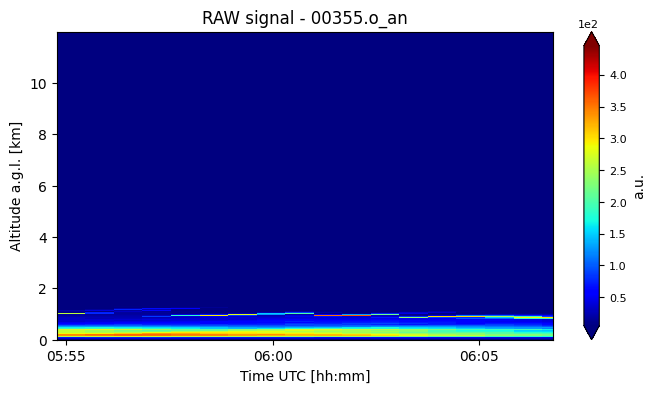

In [3]:
measurement_all.channels['00355.o_an'].plot(signal_type='raw')

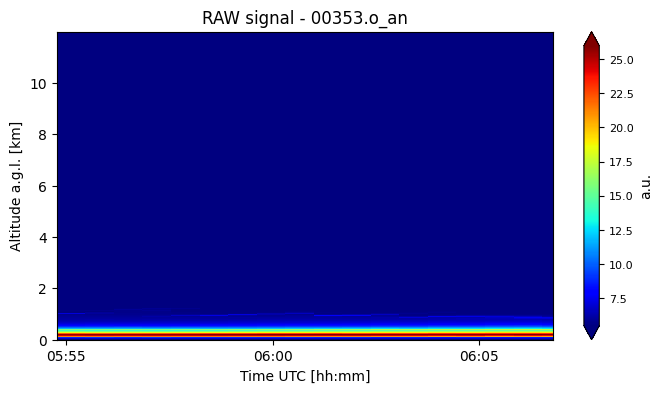

In [4]:
measurement_all.channels['00353.o_an'].plot(signal_type='raw')


In [5]:
# Subset by channels
# Licel Channels of interest
licel_channels_names = ['00355.o_an', '00353.o_an',  '00371.o_an', '00395.s_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']
licel_channels_id = {k: v for v, k in enumerate(licel_channels_names)}

#licel_channels_names = ['00355.o_an', '00395.s_an', '00353.o_an', '00371.o_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']
#licel_channels_names = ['00355.o_an', '00395.s_an']
measurement = measurement_all.subset_by_channels(licel_channels_names)

In [6]:
# Range correction
bin_min = -2000
bin_max = -500
bin_zero = 0
for channel in licel_channels_names:
    measurement.channels[channel].calculate_rc()

In [7]:
# Build raw signal and range corrected matrix
raw_signal = []
rc_signal = []
distance = []
for channel in licel_channels_names:
    raw_signal.append(np.mean(measurement.channels[channel].matrix, axis=0))
    rc_signal.append(np.mean(measurement.channels[channel].rc, axis=0))
    distance.append(measurement.channels[channel].z)


raw_signal =np.array(raw_signal)
rc_signal = np.array(rc_signal)
distance = np.array(distance)[0]

In [8]:
# select signal source

# raw_signal é melhor que range corrected pq evidencia sinais mais próximos do lidar. Melhor para visualizar pequenos sinais
# Retira background
signal = raw_signal
bin_min = -1000
bin_max = -500
background = np.mean(raw_signal[:,bin_min:bin_max], axis=1)
print("Background level: {}".format(background))
signal = np.transpose(np.transpose(raw_signal) - background)

#clipa na região de interesse
signal_subset = signal[:,0:500]
distance_subset = distance[0:500]

Background level: [5.20351268 5.49889972 5.48184738 5.53404545 5.55024397 5.54621814
 5.35260798 5.58833844]


In [9]:
def plot_matrix(distances, matrix, names, xlim = (None, None), ylim = (None, None)):
    fig, ax = plt.subplots(nrows=len(names), figsize=(10,20), layout='constrained')
    for i,trace in enumerate(matrix):
        ax[i].plot(distances, trace)
        ax[i].set_title(names[i])
        ax[i].grid(True, 'both')
        ax[i].minorticks_on()
        ax[i].set_xlabel('distance (m)')
        ax[i].set_ylabel('intensity (a.u.)')
        ax[i].set_xlim(xlim)
        ax[i].set_ylim(ylim)


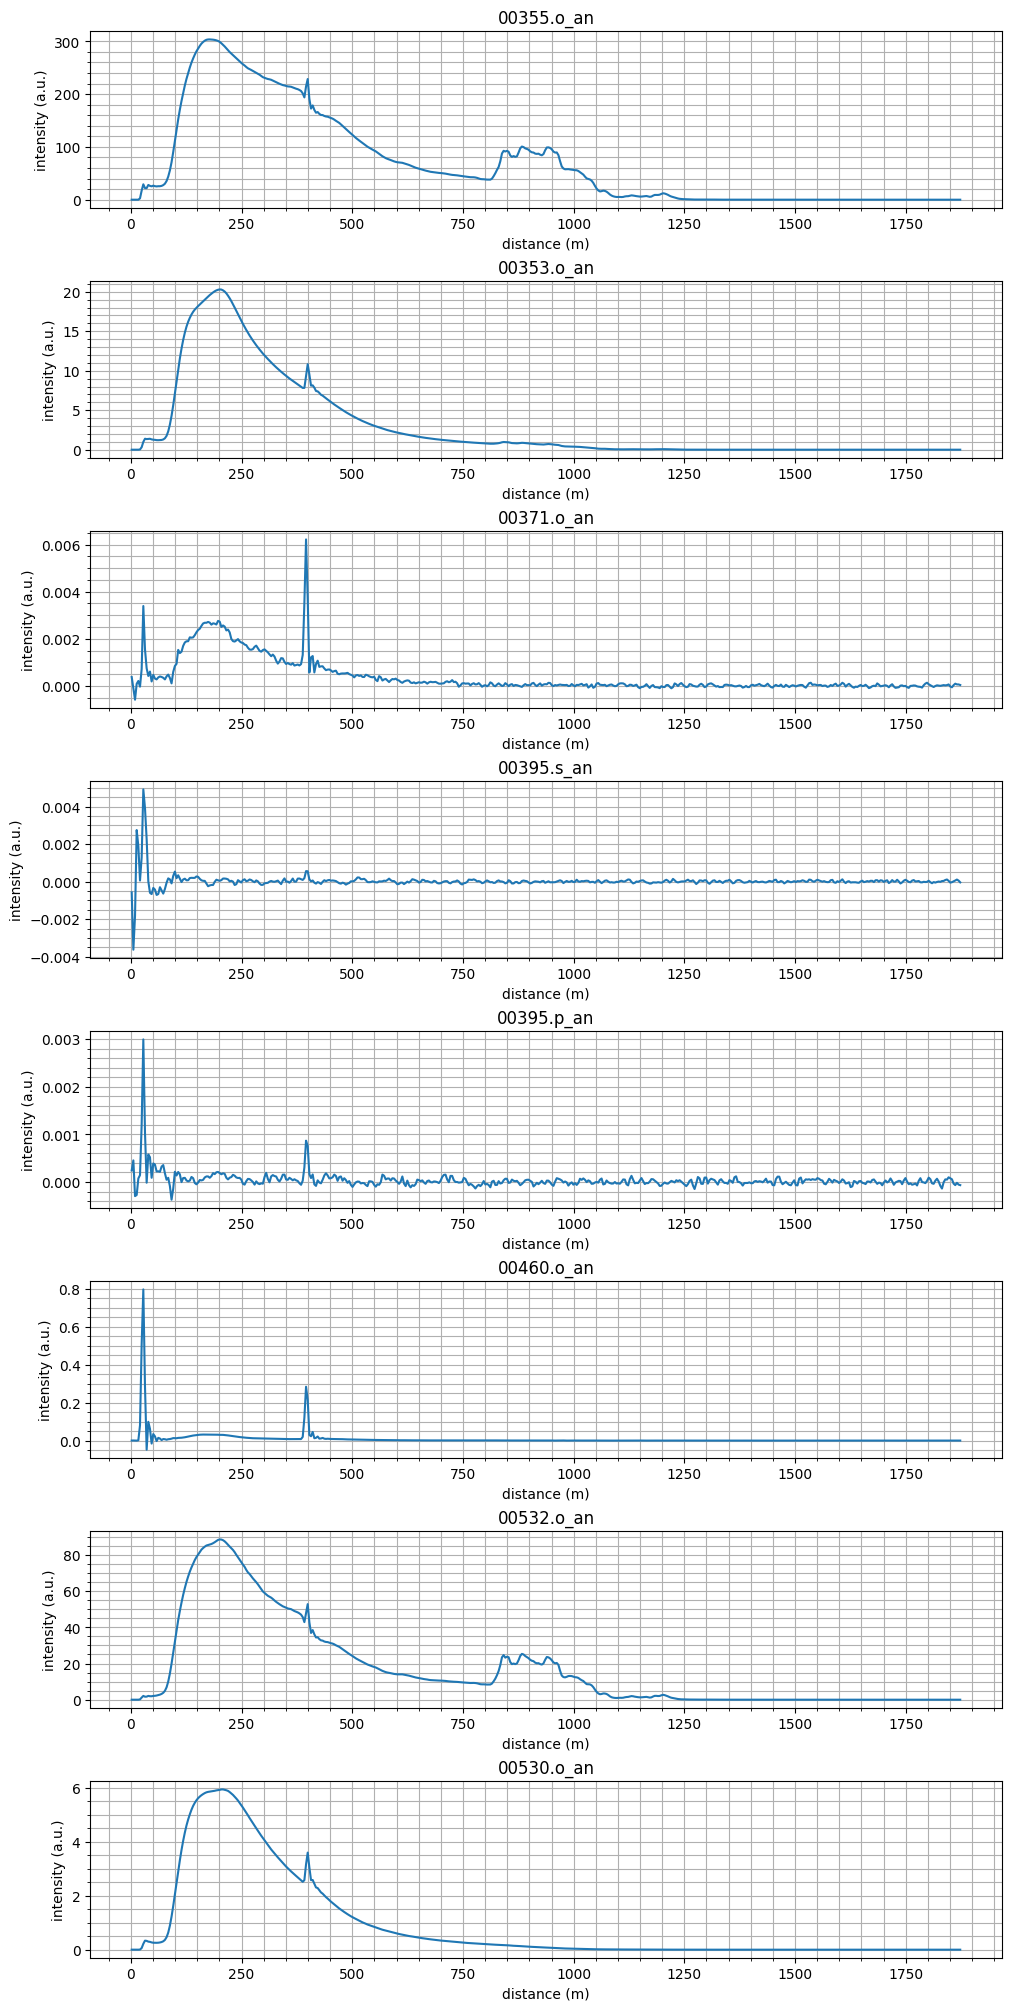

In [10]:
plot_matrix(distance_subset, signal_subset, licel_channels_names)

# Calibração

## Remoção crosstalk 355 do 353 nm
Existe crosstalk entre o 355 e 353 que precisa ser removido. Não é esperado ter crosstakl de outros canais no 353. O crosstalk é notado quando o 355 passa por nuvens e o pico aparece no 353. Em 532 também existem os picos, mas eles não aparecem no 530 nm, o que indica crosstalk no 353. O 353 é utilizado como referência para as medidas (assumindo concentração constante de N2O2), e utilizado para normalizar as medidas. O crosstalk deve ser removido. A melhor forma para fazer isso é fazer um medida com uma nuvem, idealmente numa distância que o sinal raman N2O2 já seja zero. Depois disso o fator crosstalk do 353 deve ser ajustado até casar os tamanhos dos picos de crosstalk.


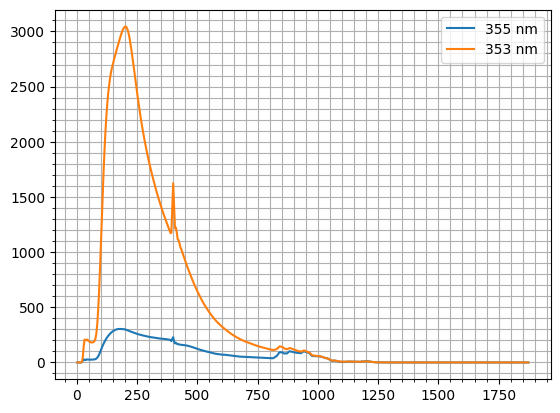

In [11]:
# Avaliação de crosstalk entre 355 e 352. Ver que exite influencia. O mesmo não ocorre em 532 e 530 nm.
bin_shift = 0
crosstalk = 150
fig, ax = plt.subplots()
ax.plot(distance_subset, signal_subset[licel_channels_id['00355.o_an']], label='355 nm')
ax.plot(distance_subset, np.roll(crosstalk*signal_subset[licel_channels_id['00353.o_an']],bin_shift), label='353 nm')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

# Sinal de referência
O sinal de referencia para normalizção é derivado p raman N2O2 (353 nm). O crosstalk do 355 é removido. Um polinomio é utilizado para fitting do decaimento. O pico de 353 no flare é parcialmente devido ao crosstalk com 355, que é espalhamento em fulígem provavelmente, mas existe ainda um residual que não sei explicar. Não deve ser fluorescência. Pode ser indicação real de diferenca na concentração de N2O2 na região de queima, ou sinal raman de outro composto.

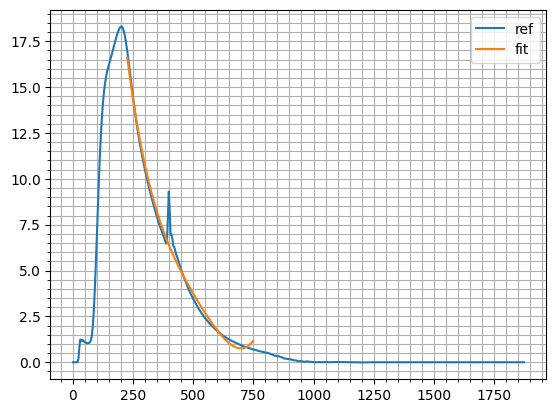

In [12]:
from scipy.optimize import curve_fit
ref_signal = signal_subset[licel_channels_id['00353.o_an']] - (1/crosstalk)*signal_subset[licel_channels_id['00355.o_an']]


# Seleciona região da curva para fitting. Pegar depois de pico
bin_min = 60
bin_max = 200
xfit = distance_subset[bin_min:bin_max]
ydata = ref_signal[bin_min:bin_max]

z = np.polyfit(xfit, ydata, 4)
f = np.poly1d(z)
fit_ref = f(xfit)

fig, ax = plt.subplots()
ax.plot(distance_subset, ref_signal, label='ref')
ax.plot(xfit, fit_ref, label='fit')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()


## Fluorescencia

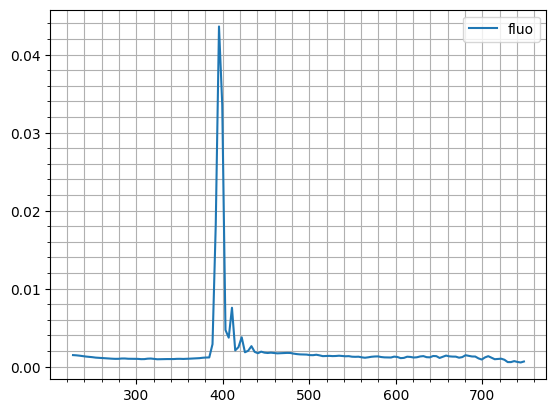

In [13]:
# Fluorescence indicator 460/ref
fluo = signal_subset[licel_channels_id['00460.o_an']][bin_min:bin_max]/fit_ref
fig, ax = plt.subplots()
ax.plot(xfit, fluo, label='fluo')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()


## CO2

np.float64(380.7317642453039)

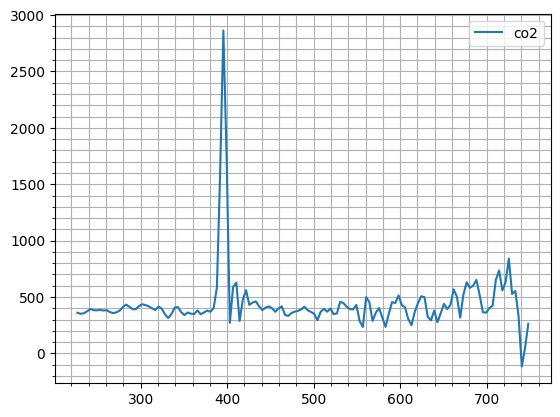

In [14]:
# CO2 = (371)/ref
gco2 = 3e6
#gfluo_co2 = 0.00235
gfluo_co2 = 0.0
co2 = gco2*((signal_subset[licel_channels_id['00371.o_an']][bin_min:bin_max])/fit_ref - gfluo_co2*fluo)
fig, ax = plt.subplots()
ax.plot(xfit, co2, label='co2')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

np.mean(co2[0:40])
# Esperado 400ppm CO2 na atmosfera

## CH4
A teoria diz que em uma polarizaçao temos Fluorescencia + Raman, e na outra Fluorescencia, por isso precismos subtrair um sinal do outro, e em principio não temos problema de fluorescencia.

Outra forma é utilizar o canal com fluorescencia + Raman e subtrair da fluorescencia.

Não sei qual é o canal que contem Fluo + Raman. Em princípio é aquela que tem uma leve banda ao redor do pico, mas o sinal na atmosfera é muito pequeno para ser identificado

np.float64(2.796367087671871)

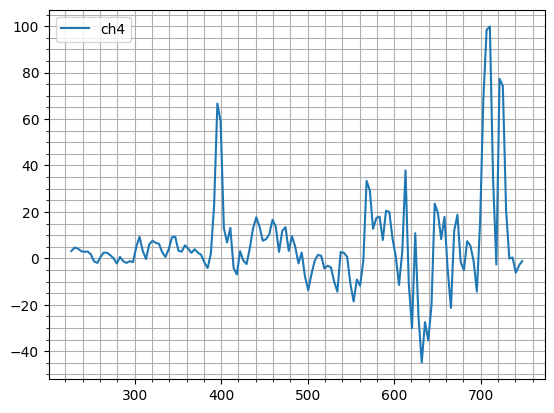

In [65]:
# CO2 = (371)/ref
gch4 = 0.5e6
gdif_ch4 = 0
gfluo_ch4 = 0

# Forma 1
ch4_1 = gch4*((signal_subset[licel_channels_id['00395.p_an']][bin_min:bin_max] - gdif_ch4*signal_subset[licel_channels_id['00395.s_an']][bin_min:bin_max])/fit_ref)
# Forma 2
ch4_2 = gch4*(signal_subset[licel_channels_id['00395.p_an']][bin_min:bin_max]/fit_ref - gfluo_ch4*fluo)

ch4= ch4_1

fig, ax = plt.subplots()
ax.plot(xfit, ch4, label='ch4')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()

np.mean(ch4[0:40])
# Esperado 2ppm CH4 na atmosfera

## CE
Eficiência de combustao pode ser calcula a parter dos valores de CH4 e CO2 pela formula. Existem duas formas de obter isso: diretamente pelo sinal raman ou pelo processado. Diretamente pelo sinal raman pode ser possível ignorar influência de Fluorescencia se assumir que ela tem influência igual nos dois canais (???)
ce = 1 /(1 + ch4/(co2 + ch4))

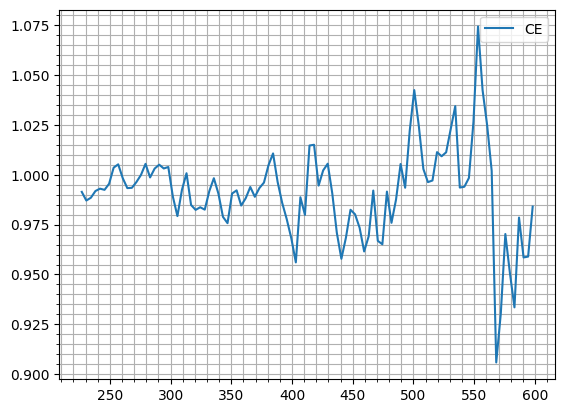

In [66]:
ce = 1 /(1 + ch4/(co2 + ch4))
fig, ax = plt.subplots()
ax.plot(xfit[0:100], ce[0:100], label='CE')
ax.legend()
ax.grid(True, 'both')
ax.minorticks_on()



Não é possível corrigir influencia da fluorescencia com facilidade. Deve ocorrer outros processo ali tb, como alteração da linha raman, largura de linha, etc. Para carcterizar isso corretamente precisamos de um espectrometro com boa resolução. As medidas fora da rergião de Fluorescencia paracem razoáveis.

Numero de arquivos: 18
PMTs Voltage [754. 756. 759. 754. 752. 755. 754. 754.]
Backgrounds [5.20361512 5.49888633 5.48184794 5.53405164 5.55022952 5.54619624
 5.35259962 5.58832817]
Flare:  {'co2': np.float64(1431.0093897042996), 'ch4': np.float64(35.302369576814186), 'ce': np.float64(0.975924376686359), 'ce_rel': np.float64(0.9741013024176134), 'fluo': np.float64(0.021057189417224065)}
Pre flare:  {'co2': np.float64(389.9436163626855), 'ch4': np.float64(5.685221425432241), 'ce': np.float64(0.9856299114664715), 'ce_rel': np.float64(0.986316329712969), 'fluo': np.float64(0.0010394681458769353)}


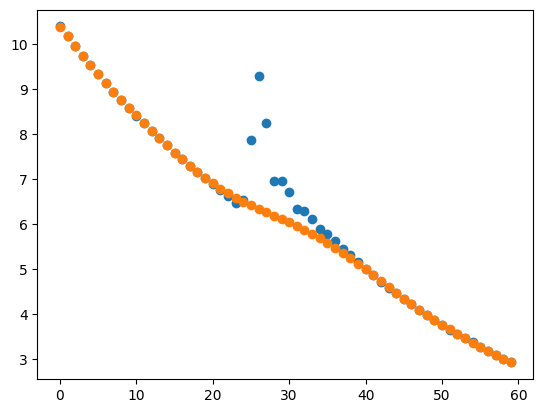

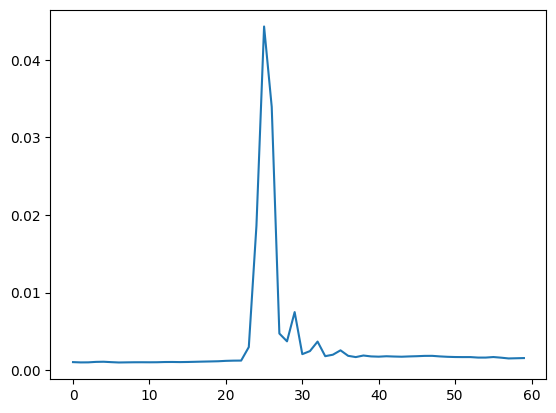

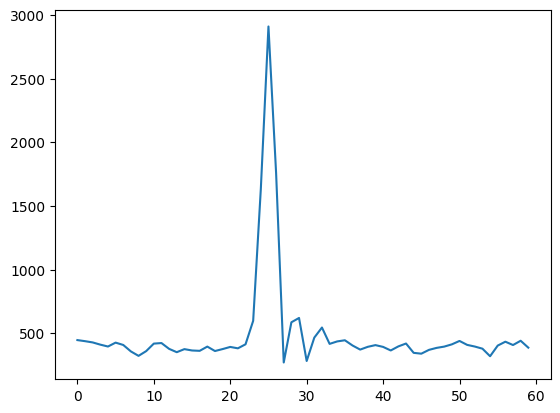

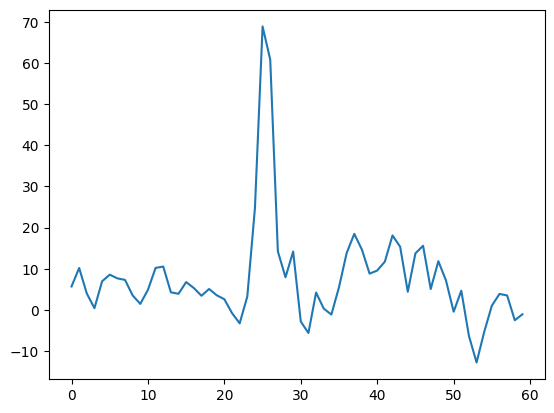

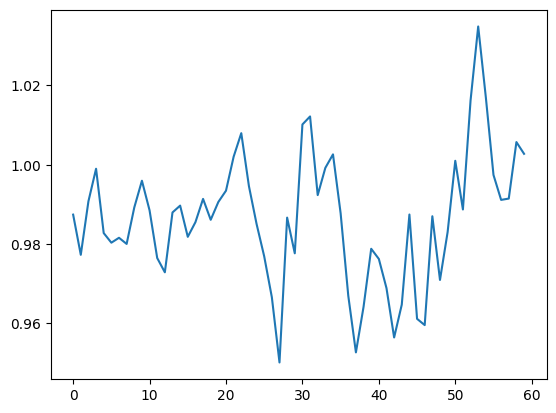

In [33]:
from scipy.optimize import curve_fit

#def emissions(files, flare_bins, pre_flare_bins, post_flare_bins, background_bins, ref_cal, ch4_cal, co2_cal):

def emissions(files, calib):


    measurement_all = LicelLidarMeasurement(files)
    licel_channels_names = ['00355.o_an', '00353.o_an',  '00371.o_an', '00395.s_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']
    licel_channels_id = {k: v for v, k in enumerate(licel_channels_names)}
    measurement = measurement_all.subset_by_channels(licel_channels_names)

    # Range correction
    for channel in licel_channels_names:
        measurement.channels[channel].calculate_rc()

    # Build raw signal and range corrected matrix
    raw_signal = []
    rc_signal = []
    distance = []
    hv = []
    for channel in licel_channels_names:
        raw_signal.append(np.mean(measurement.channels[channel].matrix, axis=0))
        rc_signal.append(np.mean(measurement.channels[channel].rc, axis=0))
        distance.append(measurement.channels[channel].z)
        hv.append(measurement.channels[channel].hv)


    raw_signal =np.array(raw_signal)
    rc_signal = np.array(rc_signal)
    # assume distance is the same for all channels
    distance = np.array(distance)[0]
    # assume voltage is the same all files
    hv = np.array(hv)[:,0]

    # raw_signal é melhor que range corrected pq evidencia sinais mais próximos do lidar. Melhor para visualizar pequenos sinais
    # Retira background
    signal = raw_signal
    #bin_min = -1000
    #bin_max = -500
    background_bins = calib['background_bins']
    background = np.mean(raw_signal[:,background_bins], axis=1)
    signal = np.transpose(np.transpose(raw_signal) - background)

    #clipa na região de interesse
    pre_flare_bins = calib['pre_flare_bins']
    post_flare_bins = calib['post_flare_bins']
    subset_min = pre_flare_bins[0]
    subset_max = post_flare_bins[1]
    signal_subset = signal[:,subset_min:subset_max]
    distance_subset = distance[subset_min:subset_max]

    # Calcula sinal de referencia
    # Avaliação de crosstalk entre 355 e 352. Ver que exite influencia. O mesmo não ocorre em 532 e 530 nm.
    bin_shift = 0
    #crosstalk = 150
    crosstalk = calib['crosstalk_355_ref']

    ref_signal = signal_subset[licel_channels_id['00353.o_an']] - (1/crosstalk)*signal_subset[licel_channels_id['00355.o_an']]

    # Seleciona região da curva para fitting. Pegar depois de pico
    #bin_min = None
    #bin_max = None
    #fit_idx = np.concatenate((x[:2], x[-2:]))
    #xfit = distance_subset[bin_min:bin_max]
    pre_len = pre_flare_bins[1] - pre_flare_bins[0]
    post_len = post_flare_bins[1] - post_flare_bins[0]
    
    # região de fitting é somente pre e post flame
    xfit = np.concatenate( (distance_subset[:pre_len], distance_subset[-post_len:]) )
    ydata = np.concatenate( (ref_signal[:pre_len], ref_signal[-post_len:]) )



    #ydata = ref_signal[bin_min:bin_max]


    z = np.polyfit(xfit, ydata, 10)
    f = np.poly1d(z)

    fit_ref = f(distance_subset)

    # Fluorescencia
    # Fluorescence indicator 460/ref
    fluo = signal_subset[licel_channels_id['00460.o_an']]/fit_ref

    # CO2 = (371)/ref
    #gco2 = 3e6
    gco2 = calib['g_co2']
    #gfluo_co2 = 0.00235
    #gfluo_co2 = 0.0
    gfluo_co2 = calib['crosstalk_fluo_co2']
    co2 = gco2*((signal_subset[licel_channels_id['00371.o_an']])/fit_ref - gfluo_co2*fluo)

    # CO2 = (371)/ref
    #gch4 = 0.5e6
    gch4 = calib['g_ch4']
    #gdif_ch4 = 0
    gdif_ch4 = calib['g_sp_ch4']
    #gfluo_ch4 = 0
    gfluo_ch4 = calib['crosstalk_fluo_ch4']

    # Forma 1
    ch4_1 = gch4*((signal_subset[licel_channels_id['00395.p_an']] - gdif_ch4*signal_subset[licel_channels_id['00395.s_an']])/fit_ref)
    # Forma 2
    ch4_2 = gch4*(signal_subset[licel_channels_id['00395.p_an']]/fit_ref - gfluo_ch4*fluo)

    ch4= ch4_1

    #ce = 1 /(1 + ch4/(co2 + ch4))
    ce_1 = co2/(co2 + ch4)
    g_ce_rel = 0.16
    ce_2 = 1/(1 + (g_ce_rel*signal_subset[licel_channels_id['00395.p_an']]/signal_subset[licel_channels_id['00371.o_an']]))

    ce = ce_1

    flare_bins = calib['flare_bins']
    rel_idx_min = flare_bins[0] - subset_min
    rel_idx_max = flare_bins[1] - subset_min
    flare_co2 = np.mean(co2[rel_idx_min:rel_idx_max])
    flare_ch4 = np.mean(ch4[rel_idx_min:rel_idx_max])
    flare_ce = flare_co2/(flare_ch4 + flare_co2)
    flare_ce_rel = np.mean(ce_2[rel_idx_min:rel_idx_max])
    flare_fluo = np.mean(fluo[rel_idx_min:rel_idx_max])

    rel_idx_min = 0
    rel_idx_max = pre_flare_bins[1] - subset_min
    pre_flare_co2 = np.mean(co2[rel_idx_min:rel_idx_max])
    pre_flare_ch4 = np.mean(ch4[rel_idx_min:rel_idx_max])
    pre_flare_ce = pre_flare_co2/(pre_flare_ch4 + pre_flare_co2)
    pre_flare_ce_rel = np.mean(ce_2[rel_idx_min:rel_idx_max])
    pre_flare_fluo = np.mean(fluo[rel_idx_min:rel_idx_max])

    output = {
        'diagnostics' :
        {
            'calibrations': calib,
            'files': files,
            'channels': licel_channels_names,
            'hv': hv,
            'signal': signal,
            'background': background,
            'reference': ref_signal,
            'fitting': fit_ref,
            'fluorescence': fluo,
            'co2': co2,
            'ch4': ch4,
            'ce': ce,
            'ce_rel': ce_2,
            'distances': distance
        },
        'pre_flare' : {
            'co2': pre_flare_co2,
            'ch4': pre_flare_ch4,
            'ce': pre_flare_ce,
            'ce_rel' : pre_flare_ce_rel, 
            'fluo': pre_flare_fluo,
        },
        'flare' : {
            'co2': flare_co2,
            'ch4': flare_ch4,
            'ce': flare_ce,
            'ce_rel': flare_ce_rel,
            'fluo': flare_fluo
        }
    }

    return output


calibrations = {
    'crosstalk_355_ref': 150,
    'g_co2': 3e6,
    'crosstalk_fluo_co2': 0,
    'g_ch4': 0.5e6,
    'crosstalk_fluo_ch4': 0,
    'g_sp_ch4': 0,
    'g_ce_relative': 0.16,
    'pre_flare_bins': (80,100),
    'post_flare_bins': (120,140),
    'flare_bins': (104,109),
    'background_bins': (15000, 16000)
}


#flare_emissions = emissions(files=files[:], flare_bins=(104,109),  pre_flare_bins=(80, 100), post_flare_bins = (120, 140), background_bins=(-1000,-500), ref_cal=0, ch4_cal=0, co2_cal=0)

flare_emissions = emissions(files=files[:], calib = calibrations)
print('Numero de arquivos: {}'.format(len(flare_emissions['diagnostics']['files'])))
print('PMTs Voltage {}'.format(flare_emissions['diagnostics']['hv']))
print('Backgrounds {}'.format(flare_emissions['diagnostics']['background']))
print('Flare: ',flare_emissions['flare'])
print('Pre flare: ',flare_emissions['pre_flare'])

plt.plot(flare_emissions['diagnostics']['reference'], 'o')
plt.plot(flare_emissions['diagnostics']['fitting'], 'o')
plt.show()
plt.plot(flare_emissions['diagnostics']['fluorescence'])
plt.show()
plt.plot(flare_emissions['diagnostics']['co2'])
plt.show()
plt.plot(flare_emissions['diagnostics']['ch4'])
plt.show()
plt.plot(flare_emissions['diagnostics']['ce'])



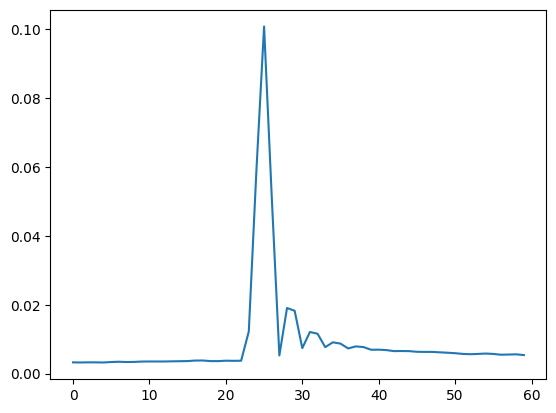

In [22]:
plt.plot(flare_emissions['diagnostics']['fluorescence'])

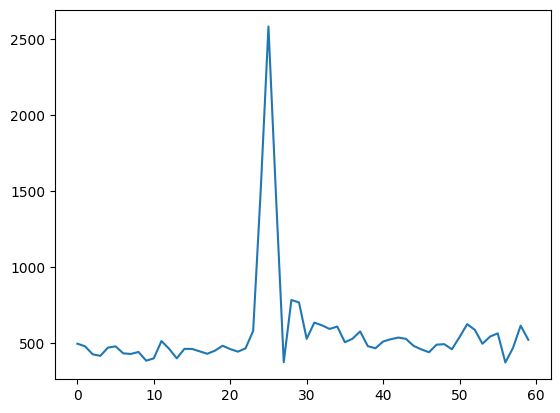

In [23]:
plt.plot(flare_emissions['diagnostics']['co2'])

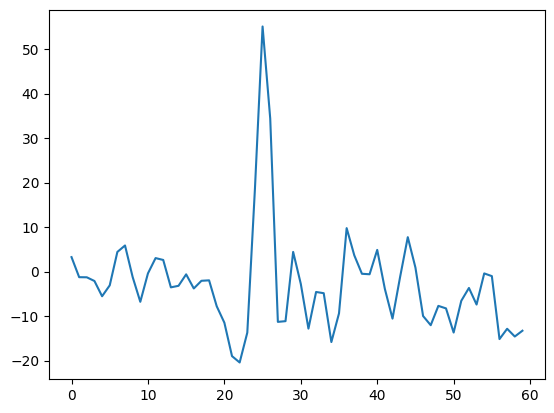

In [24]:
plt.plot(flare_emissions['diagnostics']['ch4'])

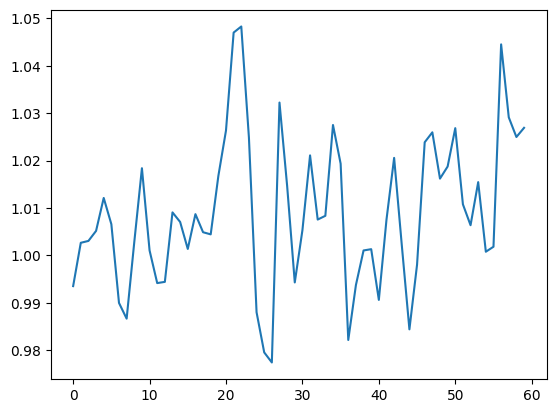

In [25]:
plt.plot(flare_emissions['diagnostics']['ce'])

In [26]:
x[:2]

NameError: name 'x' is not defined

In [69]:
np.concatenate((x[:2], x[-2:]))

array([10.42519755, 10.19177182,  3.15328135,  2.77332429])

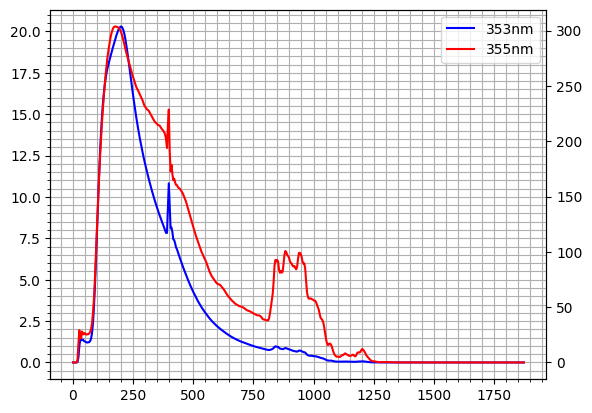

In [17]:
# Referencia
# Canal photocounting pode ser melhor para analisar sinais pequenos de Raman em CO2 e CH4. Em medidas com boa atmosfera o sinal de referencia
# em 353 chega até un 2 ou 3 km somente.
# Calculate reference signal - 353 nm
# antistoke tem crosstalk com 355
# Existe crosstalk to 355 no 353. COmparar com o 532 e 530 nm, que não tem cross talk.

#ref_signal = signal_subset[licel_channels_id['00353.o_an']] - (1/crosstalk)*signal_subset[licel_channels_id['00355.o_an']]
#plt.plot(distance_subset, signal_subset[licel_channels_id['00353.o_an']], distance_subset, signal_subset[licel_channels_id['00355.o_an']])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax3 = ax1.twinx()

ax1.plot(distance_subset, signal_subset[licel_channels_id['00353.o_an']], color='blue', label='353nm')
ax1.set_ylim(None, None)
ax2.plot(distance_subset, signal_subset[licel_channels_id['00355.o_an']], color='red', label='355nm')
#ax3.plot(distance_subset, ref_signal)

ax1.grid(True, 'both')
ax1.minorticks_on()

#ax1.legend()
#ax2.legend(loc=0)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


#plt.plot(distance_subset, signal_subset[licel_channels_id['00353.o_an']])
#plt.grid(True, 'both')
#plt.minorticks_on()
#plt.twinx()
#plt.plot(distance_subset, signal_subset[licel_channels_id['00355.o_an']])
#plt.twinx()
plt.show()





In [ ]:
# Fluorescence indicator 460/ref
fluo = gain_corrected_signal[licel_channels_id['00460.o_an']]/ref_signal

# CH4 = (395p - 395s)/ref
ch4 = 200*(gain_corrected_signal[licel_channels_id['00395.p_an']])/ref_signal - 0*fluo

# CO2 = (371)/ref
co2 = 8.295e+04*(gain_corrected_signal[licel_channels_id['00371.o_an']])/ref_signal - 0*fluo

# CE = 1/(1+ch4/co2)
#ce = 1 / (1 + ((gain_corrected_signal[licel_channels_id['00395.p_an']])/gain_corrected_signal[licel_channels_id['00371.o_an']]))
ce = 1 /(1 + ch4/(co2 + ch4))




# Junta tudo
values = np.array([ref_signal, fluo, ch4, co2, ce ])

header = ['reference', 'fluorescence', 'CH4', 'CO2', 'CE']

plot_matrix(distance_subset, values, header)

print("CO diff {}".format(np.std(co2-400)))

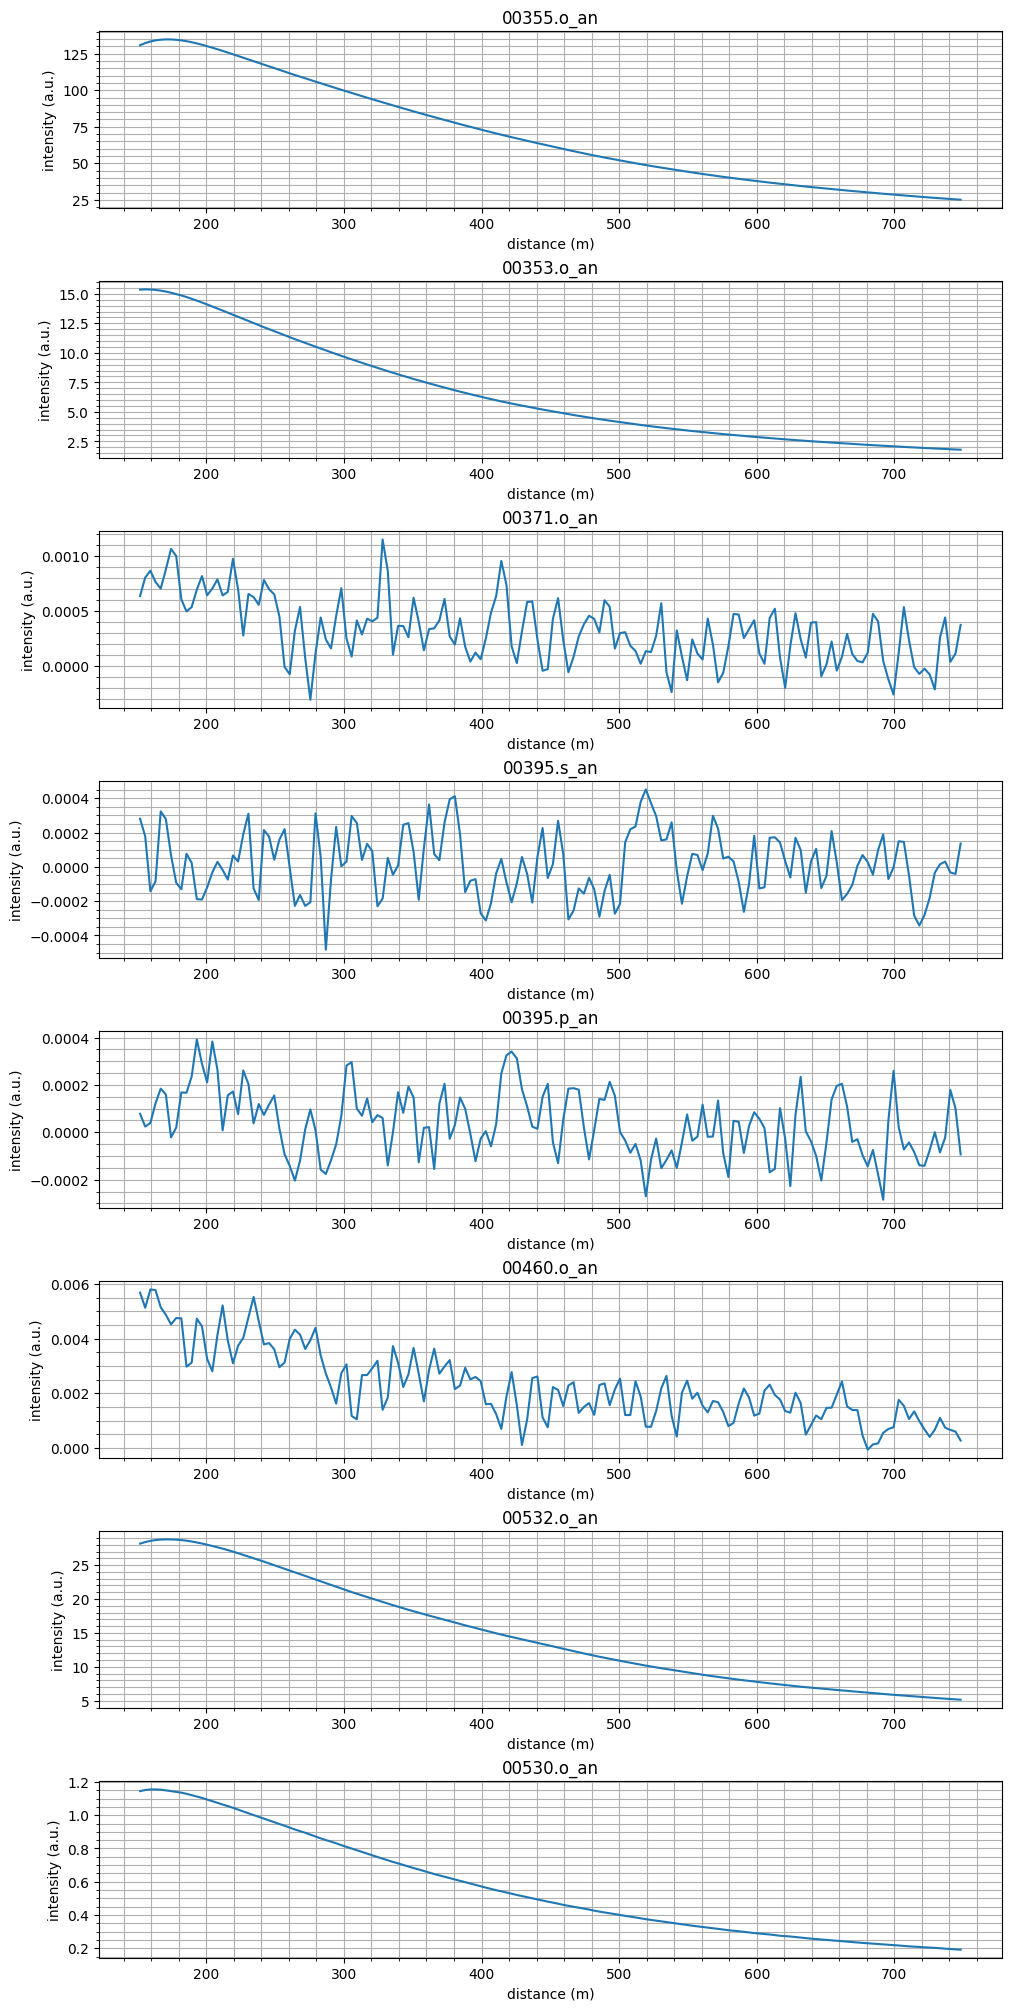

In [11]:
# Gain & Crosstalk correction
# Constantes de calibracao
# CH4
ch4_cross_355 = 0   
ch4_395s = 0
ch4_395p = 1

# CO2
co2_cross_355 = 0
co2_fluo_460 = 0
co2_fluo_ch4 = 0
co2_371 = 1

# N2/O2
n2o2_cross_355 = 0 #-0.006
n2o2_cross_532 = 0
n2o2_353 = 1
n2o2_530 = 1

# Fluorescencia
fluo_460 = 1
fluo_ch4 = 1

calib = np.array([[  ch4_cross_355, ch4_395s,        0,        0, ch4_395p,            0,              0,        0],
                  [  co2_cross_355,        0,        0,  co2_371,        0, co2_fluo_460,              0,        0],
                  [ n2o2_cross_355,        0, n2o2_353,        0,        0,            0,              0,        0],
                  [              0,        0,        0,        0,        0,            0, n2o2_cross_532, n2o2_530],
                  [              0,        0,        0,        0, fluo_ch4,            0,              0,        0],
                  [              0,        0,        0,        0,        0,     fluo_460,              0,        0],
                  [              0,        0,        0,        0,        0,            0,              0,        0],
                  [              0,        0,        0,        0,        0,            0,              0,        0],
                  ])

gain = np.array([[      1,      0,      0,      0,      0,      0,      0,      0],
                 [      0,      1,      0,      0,      0,      0,      0,      0],
                 [      0,      0,      1,      0,      0,      0,      0,      0],
                 [      0,      0,      0,      1,      0,      0,      0,      0],
                 [      0,      0,      0,      0,      1,      0,      0,      0],
                 [      0,      0,      0,      0,      0,      1,      0,      0],
                 [      0,      0,      0,      0,      0,      0,      1,      0],
                 [      0,      0,      0,      0,      0,      0,      0,      1],
                  ])

gain_corrected_signal = np.dot(gain, signal_subset)

#licel_channels_names
plot_matrix(distance_subset, gain_corrected_signal, licel_channels_names)

CO diff 5.044247905457732


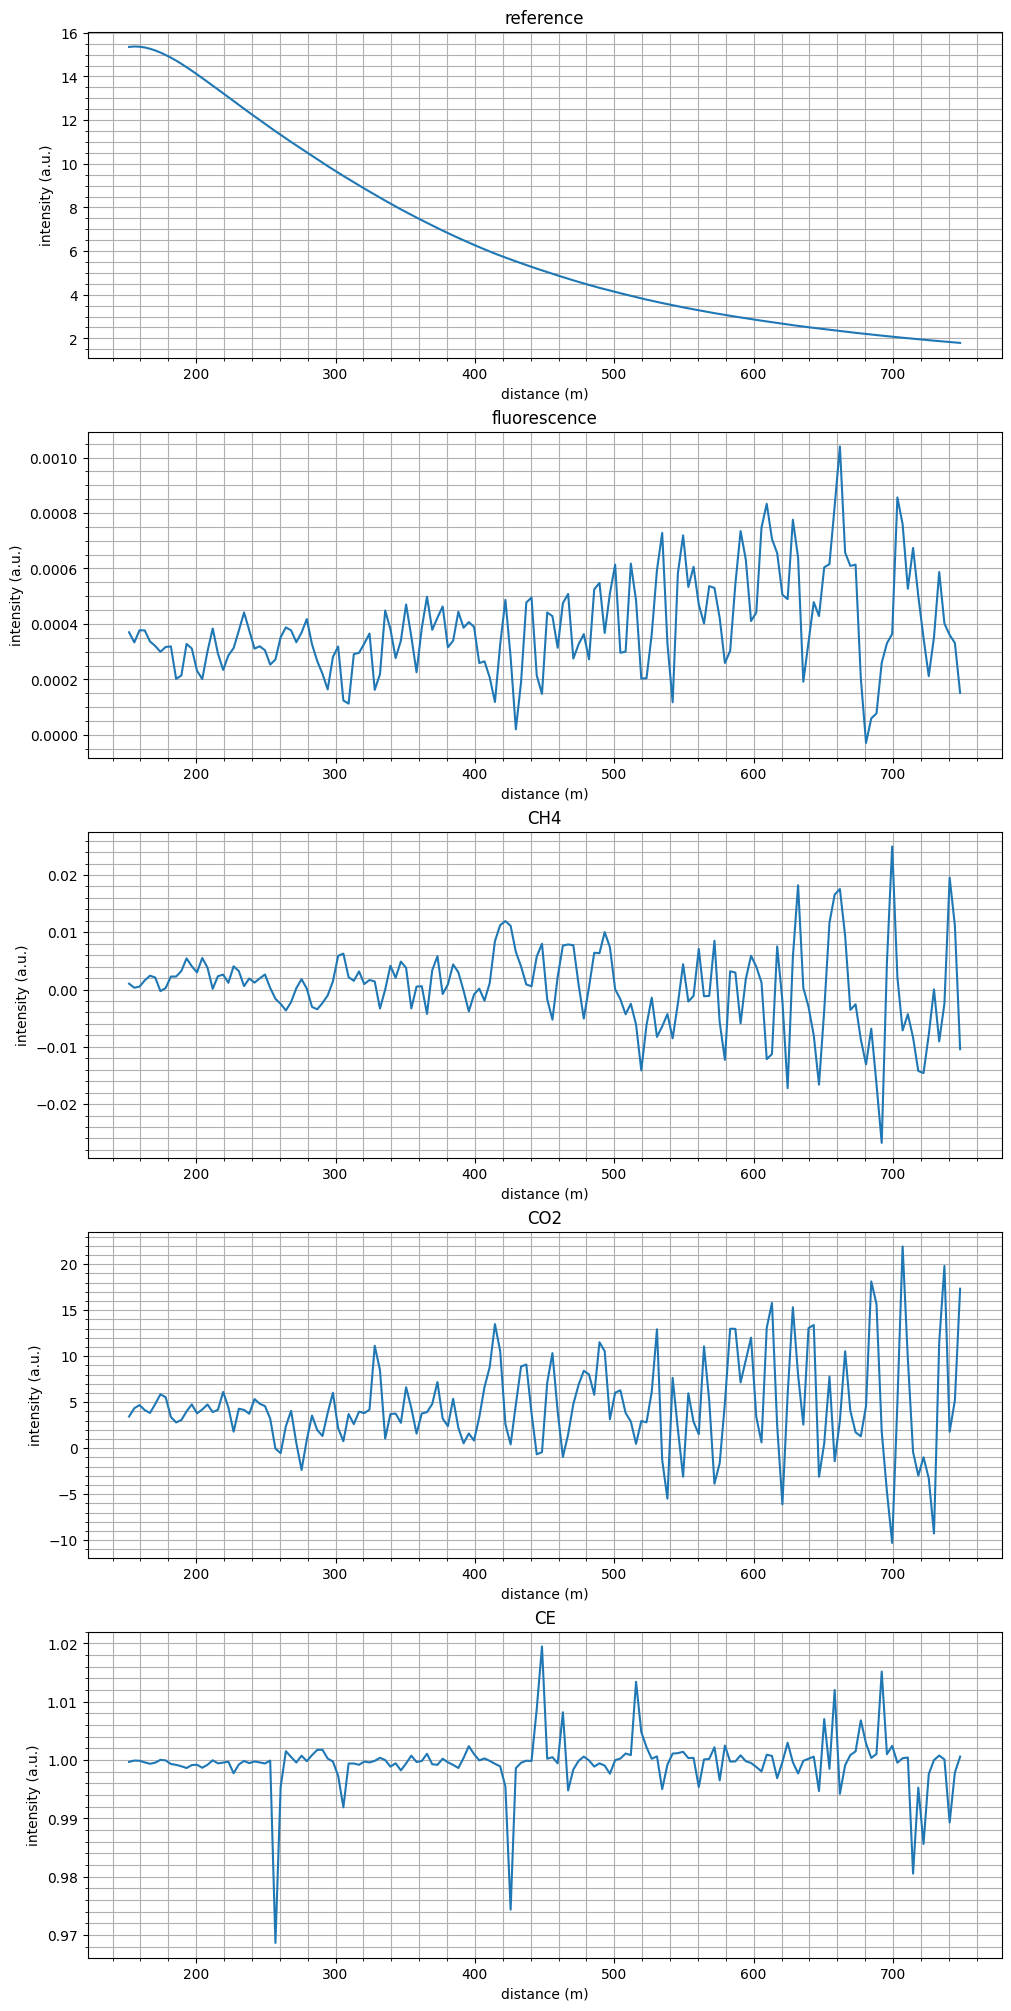

In [12]:
# Canal photocounting pode ser melhor para analisar sinais pequenos de Raman em CO2 e CH4. Em medidas com boa atmosfera o sinal de referencia
# em 353 chega até un 2 ou 3 km somente.
# Calculate reference signal - 353 nm
# antistoke tem crosstalk com 355
ref_signal = gain_corrected_signal[licel_channels_id['00353.o_an']] - 0.000*gain_corrected_signal[licel_channels_id['00355.o_an']]

# Fluorescence indicator 460/ref
fluo = gain_corrected_signal[licel_channels_id['00460.o_an']]/ref_signal

# CH4 = (395p - 395s)/ref
ch4 = 200*(gain_corrected_signal[licel_channels_id['00395.p_an']])/ref_signal - 0*fluo

# CO2 = (371)/ref
co2 = 8.295e+04*(gain_corrected_signal[licel_channels_id['00371.o_an']])/ref_signal - 0*fluo

# CE = 1/(1+ch4/co2)
#ce = 1 / (1 + ((gain_corrected_signal[licel_channels_id['00395.p_an']])/gain_corrected_signal[licel_channels_id['00371.o_an']]))
ce = 1 /(1 + ch4/(co2 + ch4))




# Junta tudo
values = np.array([ref_signal, fluo, ch4, co2, ce ])

header = ['reference', 'fluorescence', 'CH4', 'CO2', 'CE']

plot_matrix(distance_subset, values, header)

print("CO diff {}".format(np.std(co2-400)))

In [308]:
co2 = 100000*(gain_corrected_signal[licel_channels_id['00371.o_an']])/ref_signal -00*fluo
print(np.mean(co2))
print(np.std(co2))

458.66517475341624
103.95520159193421


In [286]:
# otimização parametros calibração co2
import numpy as np
from scipy.optimize import minimize

def opt_co2(x):
    co2 = (gain_corrected_signal[licel_channels_id['00371.o_an']])/ref_signal - x[0]*fluo
    return np.std(co2)

x0 = np.array([0.1])
res = minimize(opt_co2, x0, method='nelder-mead', bounds=[(0, None)], options={'disp': True})


res

Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 12
         Function evaluations: 24


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.378349016246204e-05
             x: [ 1.613e-01]
           nit: 12
          nfev: 24
 final_simplex: (array([[ 1.613e-01],
                       [ 1.613e-01]]), array([ 3.378e-05,  3.379e-05]))

In [253]:
res['x']

array([0., 0.])

In [ ]:
#ch4 = 200*(gain_corrected_signal[licel_channels_id['00395.p_an']])/ref_signal - 100*fluo


def opt_ch4(x):
    ch4 = x[0]*((gain_corrected_signal[licel_channels_id['00395.p_an']])/ref_signal - x[1]*fluo)
    return (np.std((ch4-4)**2))

x0 = np.array([10000, 100000])
res = minimize(opt_ch4, x0, method='nelder-mead', bounds=[(0, None), (0, None)], options={'disp': True})

res

Optimization terminated successfully.
         Current function value: 960.000000
         Iterations: 14
         Function evaluations: 28


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 960.0
             x: [ 0.000e+00  0.000e+00]
           nit: 14
          nfev: 28
 final_simplex: (array([[ 0.000e+00,  0.000e+00],
                       [ 0.000e+00,  0.000e+00],
                       [ 0.000e+00,  0.000e+00]]), array([ 9.600e+02,  9.600e+02,  9.600e+02]))

In [264]:
np.std(co2-1000)

np.float64(86.24123524066863)